<a href="https://colab.research.google.com/github/ryghrmni/DeepLifeProject/blob/main/Cellpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "rezaghahremani99"
os.environ['KAGGLE_KEY'] = "2de77e019555e21f9e3cf41417a6d919"

**1.3. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [3]:
!kaggle competitions download -c data-science-bowl-2018

 99% 356M/358M [00:19<00:00, 25.6MB/s]
100% 358M/358M [00:19<00:00, 19.5MB/s]


In [4]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.4. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [5]:
cd data

/content/data


In [6]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [7]:
ls

stage1_sample_submission/  stage1_test/   stage1_train_labels/             stage2_test_final/
stage1_solution/           stage1_train/  stage2_sample_submission_final/


**1.5. Required Libraries**

In [8]:
import os
import numpy as np
from PIL import Image
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import shutil

## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [9]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [10]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [11]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [12]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    #print(f"Merged mask saved at: {output_path}")

In [13]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [14]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

**2.5. Data Augmentation**

In [15]:
!pip install imgaug

In [16]:
def augment_images_and_masks(images, masks, augmenters):
    """Applies augmentation to images and masks."""
    seq_det = augmenters.to_deterministic()  # Ensures same augmentation for image and mask
    aug_images = seq_det.augment_images(images)
    aug_masks = seq_det.augment_images(masks)  # Treat masks as images for augmentation
    return aug_images, aug_masks

In [17]:
def load_image(image_path):
    """
    Load an image from the specified path and return it as a numpy array.
    Converts images to grayscale.
    """
    image = Image.open(image_path)
    image = image.convert("L")  # Convert to grayscale
    return np.array(image)

In [18]:
# Function to load masks
def load_masks(masks_path):
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [np.array(Image.open(mask_file)) for mask_file in mask_files]
    return masks

In [19]:
def save_image(image_array, output_path):
    """
    Save a numpy array as an image to the specified path.
    """
    image = Image.fromarray(image_array)
    image.save(output_path)

In [20]:
def create_augmented_folder(base_path, sample_name, num_augments=5):
    """
    Create augmented images for a given sample and save them in separate folders within the base_path directory.
    """
    sample_folder = os.path.join(base_path, sample_name)
    images_path = os.path.join(sample_folder, 'images')
    masks_path = os.path.join(sample_folder, 'merged_masks')

    # Load the image
    image_files = [f for f in os.listdir(images_path) if f.endswith('.png')]
    if not image_files:
        print(f"No image files found in {images_path}")
        return

    image = load_image(os.path.join(images_path, image_files[0]))
    images = [image]

    # Load the corresponding mask (assumes single mask for simplicity)
    mask_files = [f for f in os.listdir(masks_path) if f.endswith('.png')]
    if not mask_files:
        print(f"No mask files found in {masks_path}")
        return

    mask = load_image(os.path.join(masks_path, mask_files[0]))
    masks = [mask]

    # Define augmentation pipeline
    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Sometimes(1.0, iaa.Affine(rotate=[90, 180, 270],  # random rotations
            scale=(0.8, 1.2),  # scaling
            fit_output=True,  # ensure output fits the original image size
        )),
        iaa.Crop(px=(10, 10, 10, 10), keep_size=True),  # Crop the image back to the original size
        iaa.Multiply((0.7, 1.3)),  # random brightness changes
        iaa.LinearContrast((0.8, 1.5)),  # random contrast changes
        iaa.CropToFixedSize(width=256, height=256)  # Ensure output size
    ])

    # Generate and save augmented images and masks
    for i in range(num_augments):
        aug_images, aug_masks = augment_images_and_masks(images, masks, augmenters)

        # Create a subfolder for each augmented image and masks within the base_path directory
        augmented_subfolder = os.path.join(base_path, f"{sample_name}_augmented_{i+1}")
        os.makedirs(augmented_subfolder, exist_ok=True)
        augmented_images_folder = os.path.join(augmented_subfolder, 'images')
        augmented_masks_folder = os.path.join(augmented_subfolder, 'merged_masks')
        os.makedirs(augmented_images_folder, exist_ok=True)
        os.makedirs(augmented_masks_folder, exist_ok=True)

        for j, aug_image in enumerate(aug_images):
          save_image(aug_image, os.path.join(augmented_images_folder, f"{sample_name}_aug_{i+1}.png"))
        for j, aug_mask in enumerate(aug_masks):
          save_image(aug_mask, os.path.join(augmented_masks_folder, f"{sample_name}_aug_{i+1}_merged_mask.png"))


    print(f"Augmented data saved in separate folders within {base_path} for sample: {sample_name}")

In [21]:
"""import os
import shutil

def delete_augmented_folders(base_path):
    # Traverse through the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        # Check if it is a directory and contains "augmented" in the name
        if os.path.isdir(folder_path) and "augmented" in folder_name:
            # Delete the directory
            shutil.rmtree(folder_path)
            #print(f"Deleted folder: {folder_path}")

# Example usage
base_path = '/content/data/stage1_train'  # Update with your actual base path
delete_augmented_folders(base_path)"""

'import os\nimport shutil\n\ndef delete_augmented_folders(base_path):\n    # Traverse through the base directory\n    for folder_name in os.listdir(base_path):\n        folder_path = os.path.join(base_path, folder_name)\n        # Check if it is a directory and contains "augmented" in the name\n        if os.path.isdir(folder_path) and "augmented" in folder_name:\n            # Delete the directory\n            shutil.rmtree(folder_path)\n            #print(f"Deleted folder: {folder_path}")\n\n# Example usage\nbase_path = \'/content/data/stage1_train\'  # Update with your actual base path\ndelete_augmented_folders(base_path)'

In [22]:
# Apply augmentation to all sample folders in the base path
def augment_all_samples(base_path, num_augments=5):
    """
    Apply augmentation to all sample folders within the base path.

    Args:
    - base_path (str): Path to the base directory containing images and masks.
    - num_augments (int): Number of augmented images to generate per sample.
    """
    sample_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_name in sample_folders:
        create_augmented_folder(base_path, sample_name, num_augments)

In [23]:
base_path = '/content/data/stage1_train'
augment_all_samples(base_path, num_augments=1)

Augmented data saved in separate folders within /content/data/stage1_train for sample: 7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2
Augmented data saved in separate folders within /content/data/stage1_train for sample: 958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f
Augmented data saved in separate folders within /content/data/stage1_train for sample: f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab
Augmented data saved in separate folders within /content/data/stage1_train for sample: 8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca
Augmented data saved in separate folders within /content/data/stage1_train for sample: 4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f
Augmented data saved in separate folders within /content/data/stage1_train for sample: 5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974
Augmented data saved in separate folders within /content/data/stage1_train for sample: 6

**2.4. Data organization**

In [24]:
"""import shutil
import os

def delete_folder(folder_path):

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder does not exist: {folder_path}")

# Define paths to the folders
train_folder = '/content/data/train'
test_folder = '/content/data/test'

# Delete the folders
delete_folder(train_folder)
delete_folder(test_folder)"""

'import shutil\nimport os\n\ndef delete_folder(folder_path):\n\n    if os.path.exists(folder_path):\n        shutil.rmtree(folder_path)\n        print(f"Deleted folder: {folder_path}")\n    else:\n        print(f"Folder does not exist: {folder_path}")\n\n# Define paths to the folders\ntrain_folder = \'/content/data/train\'\ntest_folder = \'/content/data/test\'\n\n# Delete the folders\ndelete_folder(train_folder)\ndelete_folder(test_folder)'

In [25]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

# def preprocessing(img):
#     image = np.array(img)

#     # Check if the image is already grayscale
#     if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
#         gray = image
#     else:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     if len(image.shape) == 2:  # If the image is already 2D (grayscale)
#         image = np.stack((gray,)*3, axis=-1)
#     else:  # If the image is 3D (color)
#         image = np.zeros_like(image)
#         image[:, :, 0] = gray
#         image[:, :, 1] = gray
#         image[:, :, 2] = gray

#     image = standardize(image)
#     image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
#     return image


In [26]:
def preprocess_and_save_image(image_path, destination_path):
    """
    Resize an image to the specified size and save it to the destination path.

    Args:
    - image_path (str): Path to the original image.
    - destination_path (str): Path to save the resized image.
    - size (tuple): The target size for the image.
    """
    image = Image.open(image_path).convert('L')
    image = standardize(image)

    # Convert the NumPy array back to a PIL Image object
    image = Image.fromarray((image * 255).astype(np.uint8))
    # plt.imshow(image)
    # plt.axis('off')  # Turn off axis
    # plt.show()
    image.save(destination_path)

In [27]:
# def resize_and_save_image(image_path, destination_path, size=(256, 256)):
#     """
#     Resize an image to the specified size and save it to the destination path.

#     Args:
#     - image_path (str): Path to the original image.
#     - destination_path (str): Path to save the resized image.
#     - size (tuple): The target size for the image.
#     """
#     image = Image.open(image_path).convert('L')  # Convert image to grayscale
#     resized_image = image.resize(size, Image.LANCZOS)
#     resized_image.save(destination_path)

In [28]:
def extract_images(stage1_path, destination_path, content_type='images', size=(256, 256)):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder,
    resize them, and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'masks').
    - size (tuple): The target size for the images/masks.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Determine the base name for renaming
                    if 'augmented' in sample_folder:
                        # For augmented images/masks
                        parts = sample_folder.split('_')
                        base_name = parts[0] + '_aug_' + parts[-1]
                    else:
                        # For original images/masks
                        base_name = sample_folder

                    # Adjust name for masks if needed
                    if content_type == 'masks':
                        base_name += '_merged_mask'

                    # Construct the destination file path
                    destination_file_path = os.path.join(destination_path, f"{base_name}.png")

                    # Resize and save the image/mask
                    preprocess_and_save_image(file_path, destination_file_path)
                    print(f"Copied and resized: {file_path} to {destination_file_path}")

In [29]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/stage1_test'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [30]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

Copied and resized: /content/data/stage1_train/7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2/images/7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2.png to /content/data/train/images/7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2.png
Copied and resized: /content/data/stage1_train/7af09f98ec299ba0658d759eebc4c34e1c98289ea6ce37f233e9f5e4e2fc84f4_augmented_1/images/7af09f98ec299ba0658d759eebc4c34e1c98289ea6ce37f233e9f5e4e2fc84f4_aug_1.png to /content/data/train/images/7af09f98ec299ba0658d759eebc4c34e1c98289ea6ce37f233e9f5e4e2fc84f4_aug_1.png
Copied and resized: /content/data/stage1_train/958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f/images/958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f.png to /content/data/train/images/958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f.png
Copied and resized: /content/data/stage1_train/f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab/ima

<ipython-input-25-3792b12d2fe3>:4: RuntimeWarning: divide by zero encountered in divide
  x /= np.percentile(x, 98)
<ipython-input-25-3792b12d2fe3>:4: RuntimeWarning: invalid value encountered in divide
  x /= np.percentile(x, 98)
<ipython-input-26-4464c496f613>:14: RuntimeWarning: invalid value encountered in cast
  image = Image.fromarray((image * 255).astype(np.uint8))


Copied and resized: /content/data/stage1_train/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974/images/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974.png to /content/data/train/images/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974.png
Copied and resized: /content/data/stage1_train/670ebd9d674be236b9bf0b28650ad3f68e1891b06e16a9021fd069ca7ef32b78/images/670ebd9d674be236b9bf0b28650ad3f68e1891b06e16a9021fd069ca7ef32b78.png to /content/data/train/images/670ebd9d674be236b9bf0b28650ad3f68e1891b06e16a9021fd069ca7ef32b78.png
Copied and resized: /content/data/stage1_train/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339_augmented_1/images/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339_aug_1.png to /content/data/train/images/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339_aug_1.png
Copied and resized: /content/data/stage1_train/30311520606ec99b6a810ae1a9a753df991777d374212423bb075c408a98ed74_aug

This section ensures that all images are **the same size**, and in the **grayscale** channel.

In [31]:
def is_grayscale(image_path):
    """
    Check if an image is in grayscale.

    Args:
    - image_path (str): Path to the image.

    Returns:
    - bool: True if the image is in grayscale, False otherwise.
    """
    image = Image.open(image_path)
    # Convert image to numpy array
    image_np = np.array(image)
    # Check if the image has only one channel (grayscale)
    return len(image_np.shape) == 2

In [32]:
def get_image_shape(image_path):
    """
    Get the shape (size) of an image.

    Args:
    - image_path (str): Path to the image.

    Returns:
    - tuple: The shape of the image (height, width).
    """
    image = Image.open(image_path)
    return image.size  # Returns (width, height)

In [33]:
def check_images_in_folder(folder_path):
    """
    Check all images in the folder for being grayscale and their shapes.

    Args:
    - folder_path (str): Path to the folder containing the images.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder_path, filename)
            grayscale = is_grayscale(image_path)
            shape = get_image_shape(image_path)
            print(f"Image: {filename}, Grayscale: {grayscale}, Shape: {shape}")

In [34]:
folder_path = '/content/data/train/images'
check_images_in_folder(folder_path)

folder_path = '/content/data/test/images'
check_images_in_folder(folder_path)

Image: 9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de_aug_1.png, Grayscale: True, Shape: (256, 256)
Image: 3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940_aug_1.png, Grayscale: True, Shape: (221, 256)
Image: 79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96_aug_1.png, Grayscale: True, Shape: (224, 256)
Image: e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f.png, Grayscale: True, Shape: (256, 256)
Image: ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279_aug_1.png, Grayscale: True, Shape: (256, 256)
Image: 449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0.png, Grayscale: True, Shape: (696, 520)
Image: a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e_aug_1.png, Grayscale: True, Shape: (256, 256)
Image: 43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6_aug_1.png, Grayscale: True, Shape: (256, 256)
Image: 0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25

## **Step 3: Data Exploration and Visualization**

**3.1. Visualize Augmented Data:**

Check and visualize the augmented images and masks to ensure the augmentations are applied correctly.

In [35]:
def plot_augmented_sample(sample_folder):
    # for Augmented version of image and mask
    images_folder = os.path.join(sample_folder, 'images')
    masks_folder = os.path.join(sample_folder, 'merged_masks')
    image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    mask_files = [os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith('.png')]

    # for original version of image and mask
    original_images_folder = images_folder.replace("_augmented_1", "")
    original_masks_folder = masks_folder.replace("_augmented_1", "")
    original_image_files = [os.path.join(original_images_folder, f) for f in os.listdir(original_images_folder) if f.endswith('.png')]
    original_mask_files = [os.path.join(original_masks_folder, f) for f in os.listdir(original_masks_folder) if f.endswith('.png')]

    for augmented_image_file, augmented_mask_file, original_image_file, original_mask_file in zip(image_files, mask_files, original_image_files, original_mask_files):
        augmented_image = load_image(augmented_image_file)
        augmented_mask = load_image(augmented_mask_file)
        original_image = load_image(original_image_file)
        original_mask = load_image(original_mask_file)

        plt.figure(figsize=(20, 20))

        plt.subplot(2, 2, 1)
        plt.title('Original Image')
        plt.imshow(original_image)
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.title('Original Mask')
        plt.imshow(original_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.title('Augmented Image')
        plt.imshow(augmented_image)
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.title('Augmented Mask')
        plt.imshow(augmented_mask, cmap='gray')
        plt.axis('off')

        plt.show()


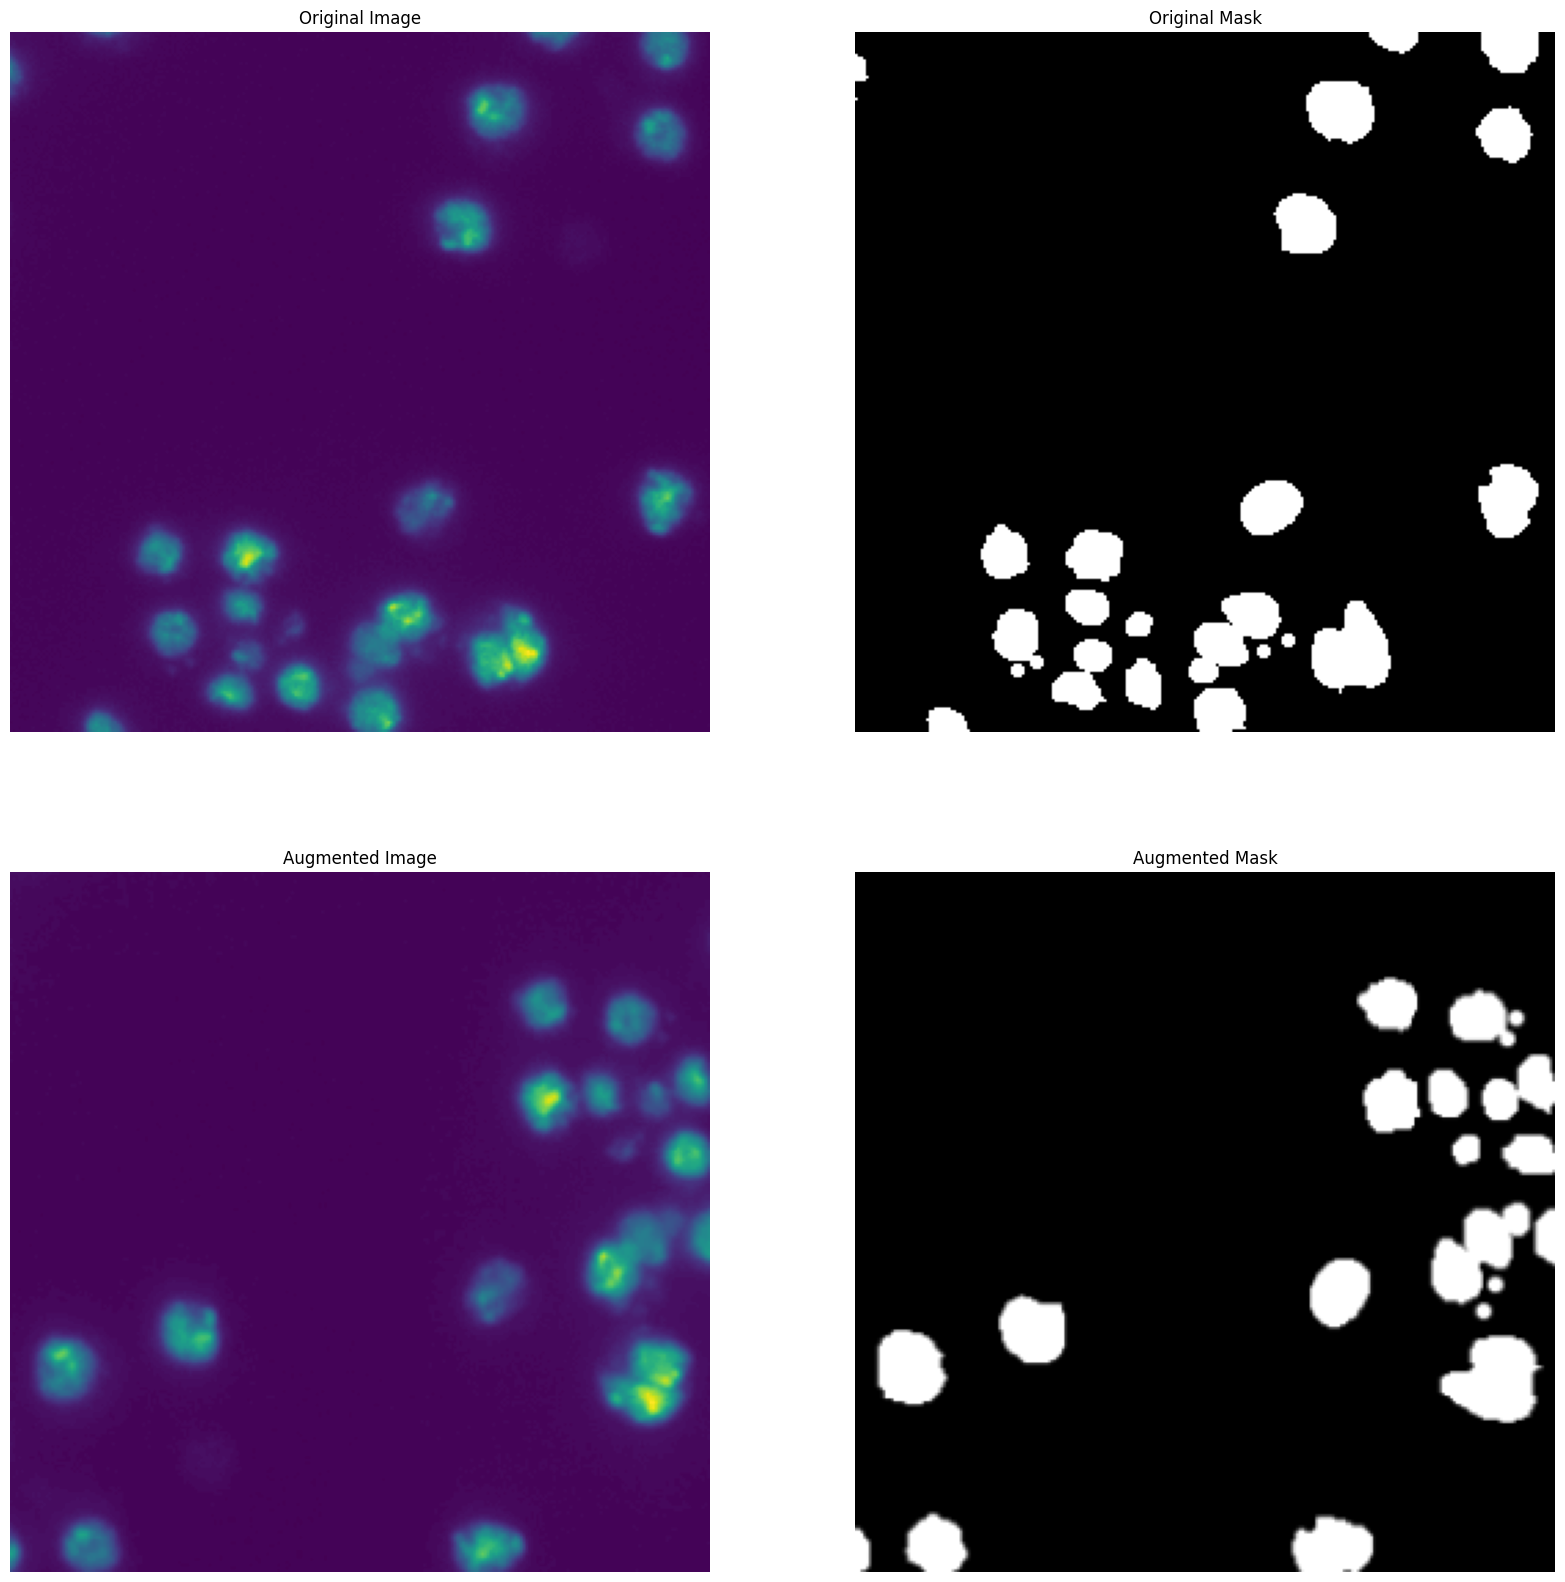

In [36]:
# Example usage
augmented_sample_folder = '/content/data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552_augmented_1'
plot_augmented_sample(augmented_sample_folder)

**3.2. Summarize Key Statistics**

Calculate and summarize key statistics about the dataset.

In [37]:
# Get a list of all sample folders
sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

# Explore the first sample
sample_folder = sample_folders[0]
image_path = os.path.join(sample_folder, 'images', os.listdir(os.path.join(sample_folder, 'images'))[0])
masks_path = os.path.join(sample_folder, 'merged_masks')

# Load the image and masks
image = load_image(image_path)
masks = load_masks(masks_path)

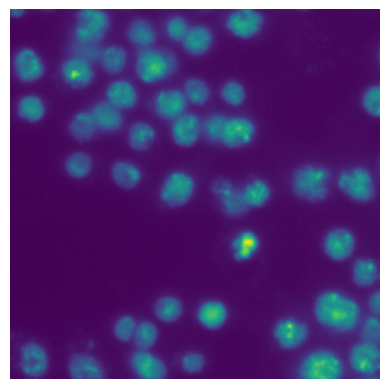

In [38]:
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

In [39]:
# Number of images
num_images = len(sample_folders)
print(f"Number of images: {num_images}")

Number of images: 1340


In [40]:
# Distribution of mask sizes
mask_sizes = []
for folder in sample_folders:
    masks = load_masks(os.path.join(folder, 'merged_masks'))
    mask_sizes.extend([np.sum(mask > 0) for mask in masks])

mask_sizes = np.array(mask_sizes)
print(f"Average mask size: {np.mean(mask_sizes):.2f} pixels")
print(f"Median mask size: {np.median(mask_sizes):.2f} pixels")

Average mask size: 21928.54 pixels
Median mask size: 12409.00 pixels


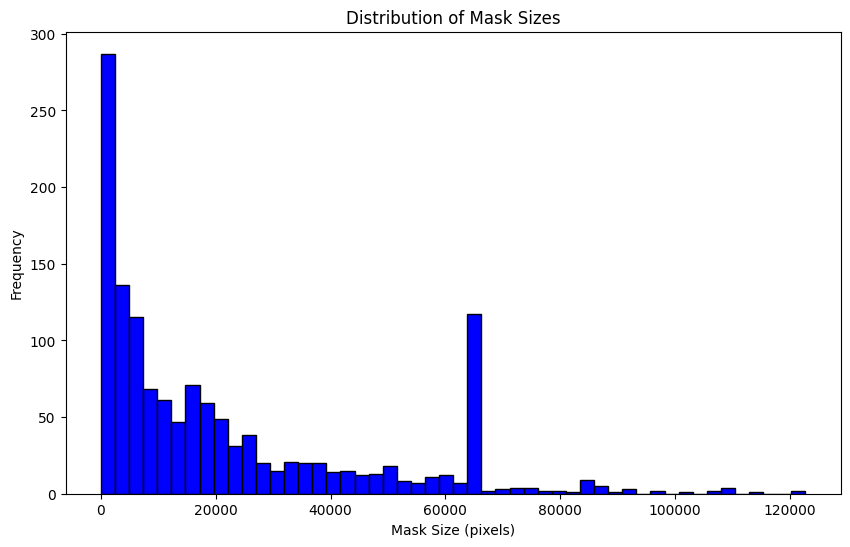

In [41]:
# Plot mask size distribution
plt.figure(figsize=(10, 6))
plt.hist(mask_sizes, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Mask Sizes')
plt.xlabel('Mask Size (pixels)')
plt.ylabel('Frequency')
plt.show()

## **Step 4: Cellpose Model**

In [42]:
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 20.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [43]:
!pip install cellpose numpy opencv-python scikit-image matplotlib

In [44]:
# Cell: Import necessary libraries
from cellpose import models, utils
import numpy as np
import cv2
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.metrics import jaccard_score
from scipy.spatial import distance

In [45]:
from cellpose import models

# Load Cellpose model (you can specify the model type: 'cyto' for cytoplasm, 'nuclei' for nuclei, or a custom model)
model = models.Cellpose(gpu=True, model_type='cyto3')

100%|██████████| 25.3M/25.3M [00:02<00:00, 9.16MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 2.85MB/s]


In [46]:
import numpy as np
import cv2
from skimage.io import imread

# Load an example image
image_path = '/content/data/train/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png'  # Update this path
image = imread(image_path)

# Preprocess the image (e.g., resizing, normalization)
# image = cv2.resize(image, (256, 256))
# image = image / 255.0  # Normalize pixel values

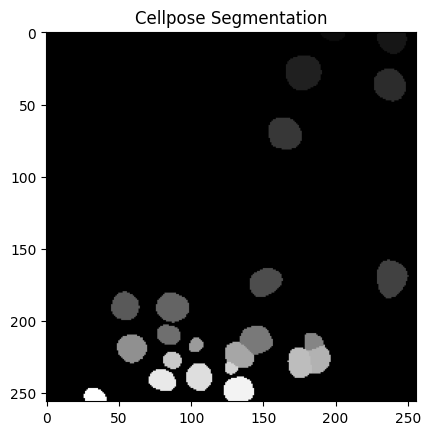

In [47]:
# Segment the image
masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0])

# Display the masks
plt.imshow(masks, cmap='gray')
plt.title('Cellpose Segmentation')
plt.show()

In [48]:
# Define paths
train_images_path = '/content/data/train/images'
train_masks_path = '/content/data/train/masks'
test_images_path = '/content/data/test/images'

# Get list of image and mask files
train_images = sorted(glob(os.path.join(train_images_path, '*.png')))
train_masks = sorted(glob(os.path.join(train_masks_path, '*_merged_mask.png')))

# Verify that images and masks match
assert len(train_images) == len(train_masks), "Number of images and masks do not match"

image_mask_pairs = []
for img_path in train_images:
    base_name = os.path.basename(img_path).split('.')[0]
    mask_path = os.path.join(train_masks_path, f"{base_name}_merged_mask.png")
    if os.path.exists(mask_path):
        image_mask_pairs.append((img_path, mask_path))
    else:
        print(f"Mask for image {img_path} not found.")

assert len(image_mask_pairs) == len(train_images), "Some images do not have corresponding masks"

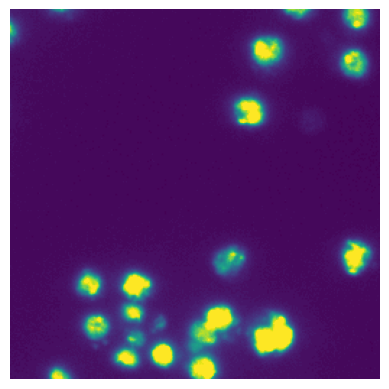

In [49]:
img = imread(train_images[0])
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [50]:
def segment_and_save(images, save_path):
    for img_path in images:
        img = imread(img_path)
        masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0, 0])

        # Convert masks to binary: set mask pixels to 255 (white) and background to 0 (black)
        binary_mask = (masks > 0).astype(np.uint8) * 255

        # Save the segmentation mask
        base_name = os.path.basename(img_path).split('.')[0]
        mask_save_path = os.path.join(save_path, f"{base_name}_segmented_mask.png")
        imsave(mask_save_path, binary_mask)

In [51]:
"""import shutil

# Path to the segmented masks folder
segmented_mask_folder = '/content/data/test/segmented_masks'

# Delete the folder and its contents
shutil.rmtree(segmented_mask_folder)

# Verify the folder has been deleted
if not os.path.exists(segmented_mask_folder):
    print(f"The folder {segmented_mask_folder} has been successfully deleted.")
else:
    print(f"Failed to delete the folder {segmented_mask_folder}.")"""

'import shutil\n\n# Path to the segmented masks folder\nsegmented_mask_folder = \'/content/data/test/segmented_masks\'\n\n# Delete the folder and its contents\nshutil.rmtree(segmented_mask_folder)\n\n# Verify the folder has been deleted\nif not os.path.exists(segmented_mask_folder):\n    print(f"The folder {segmented_mask_folder} has been successfully deleted.")\nelse:\n    print(f"Failed to delete the folder {segmented_mask_folder}.")'

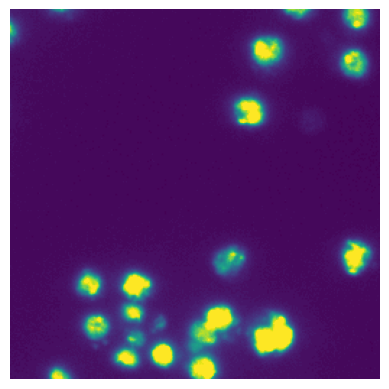

In [52]:
img = imread(image_mask_pairs[0][0])
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [53]:
# Segment and save training images
train_segmented_path = '/content/data/train/segmented_masks'

os.makedirs(train_segmented_path, exist_ok=True)
segment_and_save([pair[0] for pair in image_mask_pairs], train_segmented_path)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-50-4a673e70f8eb>:12: UserWarning: /content/data/train/segmented_masks/03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe_aug_1_segmented_mask.png is a low contrast image
  imsave(mask_save_path, binary_mask)
<ipython-input-50-4a673e70f8eb>:12: UserWarning: /content/data/train/segmented_masks/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275_aug_1_segmented_mask.png is a low contrast image
  imsave(mask_save_path, binary_mask)
<ipython-input-50-4a673e70f8eb>:12: UserWarning: /content/data/train/segmented_masks/07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770_aug_1_segmented_mask.png is a low contrast image
  i

In [54]:
# Cell: Visualize example results
def visualize_image_and_masks(image_path, predicted_mask_path, mask_path=None):
    img = imread(image_path)
    predicted_mask = imread(predicted_mask_path)

    if mask_path:
        mask = imread(mask_path)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Segmented Mask')
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
    else:
        plt.figure(figsize=(8, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Segmented Mask')

    plt.show()

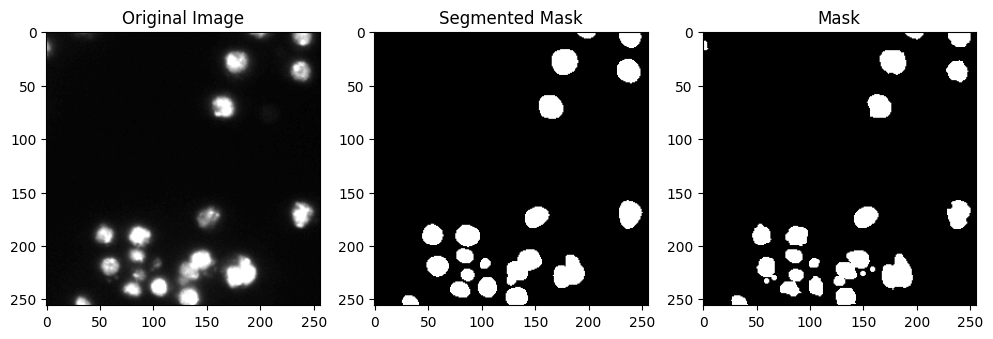

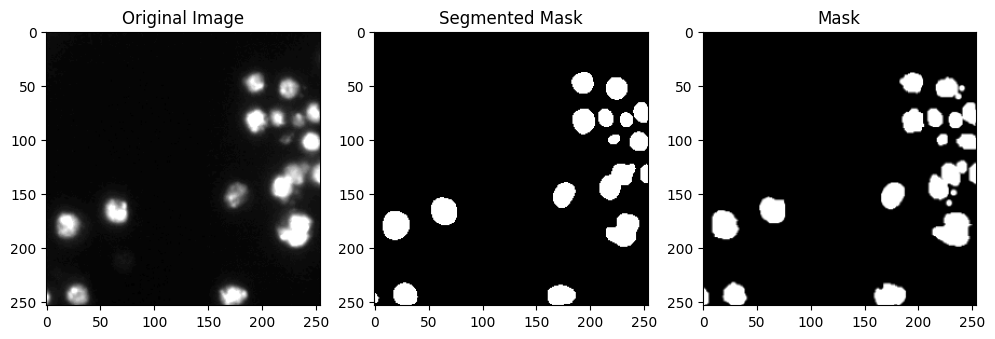

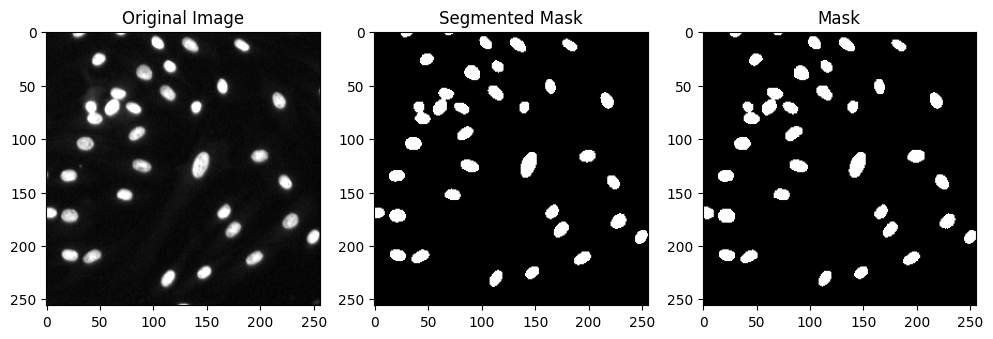

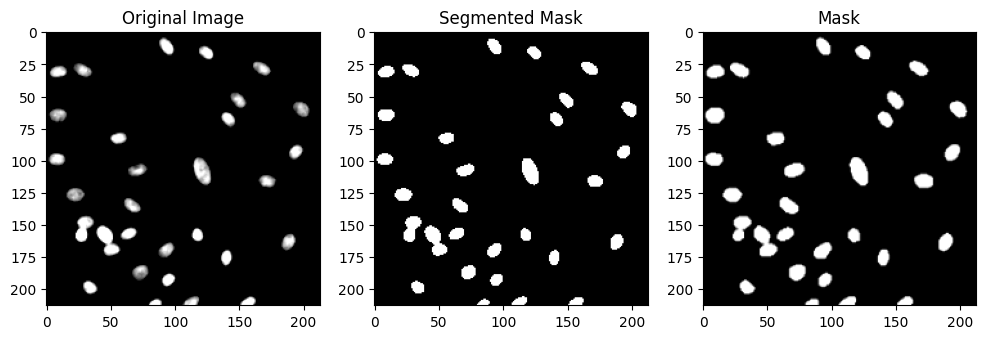

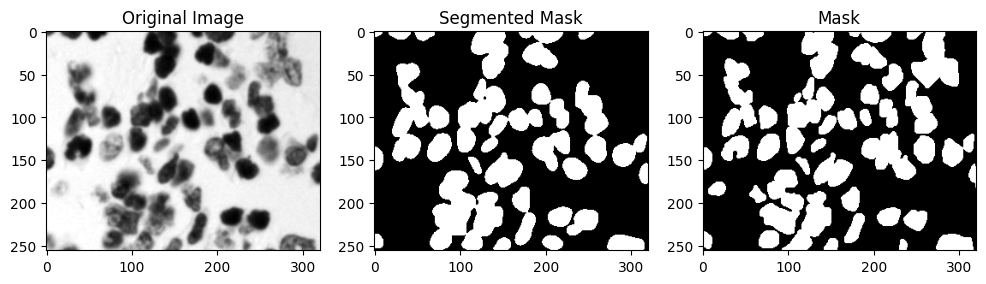

In [55]:
# Visualize a few examples
for img_path, mask_save_path in image_mask_pairs[:5]:
    mask_save_path = os.path.join(train_segmented_path, f"{os.path.basename(img_path).split('.')[0]}_segmented_mask.png")
    mask_org_path = os.path.join(train_masks_path, f"{os.path.basename(img_path).split('.')[0]}_merged_mask.png")
    visualize_image_and_masks(img_path, mask_save_path,mask_org_path)

In [56]:
# Evaluate the model

def calculate_iou(intersection, union):
    if np.sum(union) == 0:
        return 0.0
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_f_score(y_true, y_pred, average='binary'):
    f_score = f1_score(y_true, y_pred, average='binary', zero_division=0)
    return f_score


def calculate_metrics(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask)
    union = np.logical_or(true_mask, pred_mask)
    iou_score = calculate_iou(intersection, union)

    true_mask_flat = true_mask.flatten()
    pred_mask_flat = pred_mask.flatten()
    dice_score = calculate_f_score(true_mask_flat, pred_mask_flat, average='binary')

    return iou_score, dice_score

In [57]:
from sklearn.metrics import jaccard_score, f1_score

ious = []
dices = []

for img_path, mask_path in image_mask_pairs:
    true_mask = imread(mask_path) > 0
    segmented_mask_path = os.path.join(train_segmented_path, f"{os.path.basename(img_path).split('.')[0]}_segmented_mask.png")
    segmented_mask = imread(segmented_mask_path) > 0


    iou, dice = calculate_metrics(true_mask, segmented_mask)
    ious.append(iou)
    dices.append(dice)

mean_iou = np.mean(ious)
mean_dice = np.mean(dices)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice: {mean_dice}")

Mean IoU: 0.7319534635327017
Mean Dice: 0.8138731948157446


In [ ]:
test_images = sorted(glob(os.path.join(test_images_path, '*.png')))

# Cell: Segment and save test images
def segment_and_save_test(images, save_path):
    for img_path in images:
        img = imread(img_path)
        masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0, 0])

        binary_mask = (masks > 0).astype(np.uint8) * 255
        base_name = os.path.basename(img_path).split('.')[0]
        mask_save_path = os.path.join(save_path, f"{base_name}_segmented_mask.png")
        imsave(mask_save_path, binary_mask)

test_segmented_path = '/content/data/test/segmented_masks'
os.makedirs(test_segmented_path, exist_ok=True)
segment_and_save_test(test_images, test_segmented_path)

In [ ]:
# Cell: Visualize test results
for img_path in test_images[:5]:
    mask_save_path = os.path.join(test_segmented_path, f"{os.path.basename(img_path).split('.')[0]}_segmented_mask.png")
    visualize_image_and_masks(img_path, mask_save_path)